# Main Test Model
This code its the most recent and just has the necessary code to work

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import sys
from itertools import product
from lib.TechnicalIndicators import SMA, EWMA, BollingerBands

In [2]:
class MaintenanceMarginTables():
    #obtained from https://www.binance.com/en/futures/trading-rules/perpetual/leverage-margin
    
    def __init__(self):
        ### Available Maintenance Margin tables ###
        self.BTCUSDT = None
        self.BTCBUSD = None
        ########### Fill each table ##############
        d = {'Tier': range(1,11),
         'PB' : [50000, 250000, 1000000, 10000000, 20000000, 50000000, 100000000, 200000000, 300000000, 500000000], #Position Bracker (Notional Value in USDT) (top boundary)
         'ML' : [125, 100, 50, 20, 10, 5, 4, 3, 2, 1], #Max Leverage
         'MMR' : [0.004, 0.005, 0.01, 0.025, 0.05, 0.1, 0.125, 0.15, 0.25, 0.5], #Maintenance Margin Rate
         'MA' : [0, 50, 1300, 16300, 266300, 1266300, 2516300, 5016300, 25016300, 100016300] #Maintenance AMount (USDT)
        }
        self.BTCUSDT = pd.DataFrame(data = d)

        d = {'Tier': range(1,11),
         'PB' : [50000, 250000, 1000000, 7500000, 40000000, 100000000, 200000000, 400000000, 600000000, 1000000000], #Position Bracker (Notional Value in BUSD) (top boundary)
         'ML' : [50, 25, 20, 10, 6, 5, 4, 3, 2, 1], #Max Leverage
         'MMR' : [0.004, 0.005, 0.01, 0.025, 0.05, 0.1, 0.125, 0.15, 0.25, 0.5], #Maintenance Margin Rate
         'MA' : [0, 50, 1300, 16300, 203800, 2203800, 4703800, 9703800, 49703800, 199703800] #Maintenance AMount (BUSD)
        }
        self.BTCBUSD = pd.DataFrame(data = d)
        
    def get_table(self, pair):
        table = "self."+ pair.upper()
        return eval(table)
MMT = MaintenanceMarginTables()        

In [3]:
class Order():
    
    def __repr__(self):
        if self.position == 1:
            return "LONG"
        else:
            return "SHORT"
    
    def __init__(self, amount, leverage, expected_entry_price, position, created_at, 
                 fee_maker, fee_taker, use_fee, symbol, order_type = "MARKET", verbose = True):
        self.verbose = verbose
        self.symbol = symbol
        self.order_type = order_type
        self.amount = amount
        self.leverage = leverage
        self.amount_to_spend = self.amount/self.leverage #amount to really spend from my balance
        self.expected_entry_price = expected_entry_price
        self.position = position #long (1) or short (-1)
        self.fee_maker = fee_maker #comision for limit order
        self.fee_taker= fee_taker #comision for market order
        self.use_fee = use_fee #True or False
        self.created_at = created_at # creating position datetime
        ########### Open position params ###########
        self.entry_price = None
        self.opening_at = None #opening position datetime
        self.unlev_amount_to_buy_units = None
        self.amount_to_buy_units = None
        self.opening_fee_as_amount = None 
        self.opening_fee_as_units = None
        self.unlev_units = None
        self.units = None
        ########### Close position params ###########
        self.closing_at = None #close position datetime
        self.closing_fee_as_amount = None 
        self.closing_fee_as_units = None
        self.closing_price = None
        self.liquidated = False #Tells if position was liquidated
        self.liquidation_price = None
        
    def open_position(self, date, entry_price):
        self.opening_at = date # open position datetime
        if entry_price is None: 
            self.entry_price = self.expected_entry_price #for limit orders
        else:
            self.entry_price = entry_price #market orders    
        ##################### Works for long and short ##################    
        self.unlev_amount_to_buy_units = self.amount_to_spend/( 1 + self.leverage*self.fee_taker*self.use_fee )
        self.amount_to_buy_units = self.unlev_amount_to_buy_units*self.leverage
        self.opening_fee_as_amount = self.amount_to_buy_units*self.fee_taker*self.use_fee
        self.opening_fee_as_units = self.opening_fee_as_amount/self.entry_price
        self.unlev_units = self.unlev_amount_to_buy_units/self.entry_price
        self.units = self.unlev_units*self.leverage
        if self.position == 1 and self.verbose:
            print("{} |  Buying {} for {}, leverage {}".format(self.opening_at, self.units, round(self.entry_price, 5), self.leverage))
        elif self.verbose:
            print("{} |  Selling {} for {}, leverage {}".format(self.opening_at, self.units, round(self.entry_price, 5), self.leverage))
        return self.units, self.opening_fee_as_amount
        
    def get_close_fee(self, price, as_amount= True):
        #long - pay more comission if price raises
        #short - pay more comission if price falls
        fee = self.units * self.entry_price + self.position * self.units * (price - self.entry_price) 
        fee = fee * self.fee_taker
        if not as_amount: fee/=price #as units
        return fee * self.use_fee
    
    def get_PnL(self, price, include_fee = False, as_amount = True):
        #get profit (by default doesnt include fee as Binance)
        PnL = self.position * self.units * (price - self.entry_price)
        fee = self.get_close_fee(price, as_amount= True) * include_fee
        profit = PnL - fee
        if not as_amount: profit/=price
        return profit
    
    def get_position_value(self, price, include_fee = True, as_amount = True):
        #gets the spent money and profits of the position (subtracts closing fee if True)
        profit = self.get_PnL(price = price, include_fee = include_fee, as_amount = True)
        pos_val = self.unlev_amount_to_buy_units + profit
        if not as_amount: pos_val /= price
        return pos_val
    
    def close_position(self, date, price, liquidate = False):
        self.closing_at = date
        self.closing_price = price
        self.closing_fee_as_amount = self.get_close_fee(price, as_amount = True)
        self.closing_fee_as_units = self.get_close_fee(price, as_amount = False)
        pos_value = self.get_position_value(price)
        if self.position == -1 and self.verbose:
            print("{} |  Buying (closing) {} for {}".format(date, self.units, round(price, 5)))
        elif self.verbose:
            print("{} |  Selling (closing) {} for {}".format(date, self.units, round(price, 5)))  
        return pos_value
    
    def is_open(self):
        return self.closing_at is None
    
    def is_closed(self):
        return not self.is_open()
    
    def get_maintenance_margin(self, price):
        #this is an example of how to retrieve a table and the necessary row with the information.
        if self.symbol.upper() in "BTCUSDT":
            table = MMT.get_table("BTCUSDT") 
        elif self.symbol.upper() in "BTCBUSD":
            table = MMT.get_table("BTCBUSD")
        else:
            table = MMT.get_table(self.symbol)
        size = self.units*price #size of position
        #locate the corresponding row with size
        row = table.loc[ size >= table['PB'].shift(1).fillna(0) ].loc[ size < table['PB'] ]
        #get all the row values, these are the required to calculate maintenance margin.
        tier, pb, ml, mmr, ma = row.values[0]
        mm = size * mmr - ma
        return mm
    
    def calculate_margin_ratio(self, price):
        #when margin ratio == 1, that is the liquidation price
        maintenance_margin = self.get_maintenance_margin(price)
        balance = self.unlev_amount_to_buy_units #just for isolated mode (for cross you must use wallet)
        quantity = self.units
        mark_price = price #for simplicity
        entry_price = self.entry_price
        
        margin_ratio = maintenance_margin/( balance + self.position* quantity * ( mark_price - entry_price ))
        return margin_ratio
    
    def get_liquidation_price(self):
        #uses price instead of mark_price for simplicity
        #the liquidation price changes to farther when mark price gets close, so we  
        #execute this function many times to get close to the real one!!!!
        if self.liquidation_price is not None: return self.liquidation_price
        mark_price = self.entry_price
        pos = self.position
        entry_price = self.entry_price
        balance = self.unlev_amount_to_buy_units #just for isolated mode (for cross you must use wallet)
        quantity = self.units
        precision = 5 #more precision == closer you get to real liquidation price
        for i in range(precision):
            maintenance_margin = self.get_maintenance_margin(mark_price)
            liquidation_price = pos*( maintenance_margin - balance )/quantity + entry_price
            mark_price = liquidation_price
        self.liquidation_price = liquidation_price 
        return self.liquidation_price
    
    def should_liquidate(self, price): 
        if self.position == 1 and price <= self.get_liquidation_price():
            return True
        elif self.position == -1 and price >= self.get_liquidation_price():
            return True
        else:
            return False
    
    def liquidate_position(self, date):
        self.closing_at = date
        self.closing_price = self.liquidation_price
        self.liquidated = True
        if self.position == -1 and self.verbose:
            print("{} |  Buying (liquidating) {} for {}".format(date, self.units, round(self.closing_price, 5)))
        elif self.verbose:
            print("{} |  Selling (liquidating) {} for {}".format(date, self.units, round(self.closing_price, 5))) 

In [10]:
class BinanceApi():

    def __init__(self, symbol, start, end, amount, use_fee = True, fee_maker=0, fee_taker=0,
                 verbose = True, csv = "data/5m.csv"):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.csv = csv #csv to use
        self.initial_balance = amount
        self.available_balance = amount #keeps unlevered balance (real balance)
        self.open_orders = [] #stores open orders
        self.closed_orders= [] #stores closed orders
        self.PnLs = []
        self.liquidated_orders = 0 #stores count of liquidated orders
        self.trades = 0
        self.paid_fees = 0 #accumulates paid fees
        self.use_fee = use_fee
        self.fee_maker = fee_maker #limit orders fee
        self.fee_taker = fee_taker #market orders fee (higher)
        self.leverage = 1
        self.get_data()
        self.verbose = verbose
    def get_data(self):
        raw = pd.read_csv(self.csv, parse_dates = ["Date"], index_col = "Date").dropna()
        raw = raw.loc[self.start:self.end]
        raw = raw[["Close"]].rename(columns={"Close": "price"}) #just use these columns
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        raw["Hold Strategy"] = raw["returns"].cumsum().apply(np.exp) * self.initial_balance
        self.data = raw

    def plot_data(self, cols = None):  
        if cols is None:
            cols = "price"
        self.data[cols].plot(figsize = (12, 8), title = self.symbol)
    
    def get_values(self, bar):
        date = str(self.data.index[bar].date())
        price = round(self.data.price.iloc[bar], 5)
        return date, price
    
    def print_available_balance(self, bar):
        date, price = self.get_values(bar)
        print("{} | Current Balance: {}".format(date, round(self.available_balance, 2)))
        
    def buy_instrument(self, bar, units = None, amount = None):
        date, price = self.get_values(bar)
        
        if self.get_position() in [0]: #open long position
            if amount is None: amount = units*price
            order = Order(amount = amount, 
              leverage = self.leverage, 
              expected_entry_price = price,
              position = 1, 
              created_at = date,       
              fee_maker = self.fee_maker, 
              fee_taker = self.fee_taker, 
              use_fee = self.use_fee,
              symbol = self.symbol,
              verbose = self.verbose)
            if order.amount_to_spend > self.available_balance+0.1: #avoids floating errors
                self.not_enough_balance(order.amount_to_spend, self.available_balance)
                return #dont continue with operation!
            order.open_position(date = date, entry_price = price)
            self.paid_fees += order.opening_fee_as_amount
            self.open_orders.append(order)
            self.available_balance -= order.amount_to_spend
            self.trades += 1
        elif self.get_position() in [-1]: #closing short position
            order = self.open_orders[0]
            pos_value = order.close_position(date = date, price = price)
            self.paid_fees += order.closing_fee_as_amount
            self.available_balance += pos_value
            self.open_orders = []
            self.closed_orders.append(order)
            self.PnLs.append(order.get_PnL(price = price, include_fee = True))
                    
    def sell_instrument(self, bar, units = None, amount = None):
        date, price = self.get_values(bar)
        
        if self.get_position() in [0]: #open short position
            if amount is None: amount = units*price
            order = Order(amount = amount, 
              leverage = self.leverage, 
              expected_entry_price = price,
              position = -1, 
              created_at = date,       
              fee_maker = self.fee_maker, 
              fee_taker = self.fee_taker, 
              use_fee = self.use_fee,
              symbol = self.symbol,
              verbose = self.verbose)
            if order.amount_to_spend > self.available_balance+0.1: #avoids floating errors
                self.not_enough_balance(order.amount_to_spend, self.available_balance)
                return #dont continue with operation!
            order.open_position(date = date, entry_price = price)
            self.paid_fees += order.opening_fee_as_amount
            self.open_orders.append(order)
            self.available_balance -= order.amount_to_spend
            self.trades += 1
        elif self.get_position() in [1]: #closing long position
            order = self.open_orders[0]
            pos_value = order.close_position(date = date, price = price)
            self.paid_fees += order.closing_fee_as_amount
            self.available_balance += pos_value
            self.open_orders = []
            self.closed_orders.append(order)
            self.PnLs.append(order.get_PnL(price = price, include_fee = True) - order.opening_fee_as_amount)
            
    def print_current_nav(self, bar):
        nav = self.get_nav(bar)
        print("{} |  Net Asset Value = {}".format(date, round(nav, 2)))
        
    def get_nav(self, bar):
        if len(self.open_orders) == 0: return self.available_balance
        date, price = self.get_values(bar)
        order = self.open_orders[0]
        pos_value = order.get_position_value(price = price, include_fee = True, as_amount = True)
        return self.available_balance + pos_value

    def get_position(self):
        if len(self.open_orders) == 0:
            return 0
        return self.open_orders[0].position
    
    def verify_not_liquidation(self, bar):
        date, price = self.get_values(bar)
        if self.get_position() == 0: return #currently no open positions
        order = self.open_orders[0]
        if order.should_liquidate(price):
            order.liquidate_position(date = date)
            self.open_orders = []
            self.closed_orders.append(order)
            self.liquidated_orders += 1
    def not_enough_balance(self,need, have):
        print("You dont have necessary balance to open this order!: cost:{}, balance:{}".format(
                    round(need,2), round(have,2)
                ))
    def get_max_order_leverage(self, total_amount):
        if self.symbol.upper() in "BTCUSDT":
            table = MMT.get_table("BTCUSDT") 
        elif self.symbol.upper() in "BTCBUSD":
            table = MMT.get_table("BTCBUSD")
        else:
            table = MMT.get_table(self.symbol)
        max_leverage = table.loc[ total_amount <= table['PB']].ML.iloc[0]
        return max_leverage
    def get_max_order_amount(self, leverage):
        if self.symbol.upper() in "BTCUSDT":
            table = MMT.get_table("BTCUSDT") 
        elif self.symbol.upper() in "BTCBUSD":
            table = MMT.get_table("BTCBUSD")
        else:
            table = MMT.get_table(self.symbol)
        max_total_amount = table.loc[ leverage <= table['ML']].PB.iloc[-1]
        return max_total_amount
    def validate_order_amount(self, desired_amount, leverage):
        #returns a valid amount to spend with a certain leverage
        max_amount_with_lev = self.get_max_order_amount(leverage)
        max_amount_with_balance = self.available_balance*self.leverage
        amount = min(max_amount_with_lev, max_amount_with_balance, desired_amount) #respect leverage and balance restrictions!!
        if self.verbose and desired_amount != amount: print("Invalid amount for order, changing to a valid one...")
        return amount
    def change_leverage(self, new_leverage):
        current_position = self.get_position()
        if current_position: 
            print("cant change leverage with open position")
            return -1
        self.leverage = new_leverage
        return self.leverage

In [11]:
class IterativeBacktest(BinanceApi):
    
    #def __init__(self):
    #    self.strategies = [] #keeps all the strategies used
    #    self.predicted_pos = 0 #keeps current predicted position of strategies
    #    self.ind_sum = 0 #keeps current indicators sum for predicted positions
        
    # helper method
    def go_long(self, bar, units = None, amount = None):
        if self.get_position() != 0:
            self.go_neutral(bar) #if some position, go neutral first
        if self.should_end_session(): return
        self.leverage_strategy(ind_sum = self.ind_sum, ind_count = len(self.strategies))
        if units:
            self.buy_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.available_balance * self.leverage
            amount = self.validate_order_amount(amount, self.leverage)
            self.buy_instrument(bar, amount = amount) # go long

    # helper method
    def go_short(self, bar, units = None, amount = None):
        if self.get_position() != 0:
            self.go_neutral(bar) # if some position, go neutral first
        if self.should_end_session(): return
        self.leverage_strategy(ind_sum = self.ind_sum, ind_count = len(self.strategies))
        if units:
            self.sell_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.available_balance * self.leverage
            amount = self.validate_order_amount(amount, self.leverage)
            self.sell_instrument(bar, amount = amount) # go short
    
    def go_neutral(self, bar):
        if self.get_position() == 1: #if long, sell all
            self.sell_instrument(bar, units = self.open_orders[0].units)
        elif self.get_position() == -1: #if short, buy all
            self.buy_instrument(bar, units = self.open_orders[0].units)
            
    def calculate_metrics(self, bar):
        if not self.keep_metrics: return
        self.positions.append( self.get_position() )
        self.navs.append( self.get_nav(bar) )
        
    def add_metrics_to_data(self):
        if not self.keep_metrics: return
        self.data["Position"] = self.positions + [0]*( self.data.shape[0] - len(self.positions) )
        self.data["NAV"] = self.navs + [0]*( self.data.shape[0] - len(self.positions) )
        
    def close_final_position(self, bar):
        date, price = self.get_values(bar)
        self.go_neutral(bar) # if some position, go neutral
        perf = (self.available_balance - self.initial_balance) / self.initial_balance * 100
        good_trades = np.sum(np.array(self.PnLs) > 0, axis = 0)
        bad_trades = np.sum(np.array(bc.PnLs) <= 0, axis = 0)
        if self.verbose:
            self.print_available_balance(bar)
            print(75 * "-")
            print("{} | +++ CLOSING FINAL POSITION +++".format(date))
            print("{} | net performance (%) = {}".format(date, round(perf, 2) ))
            print("{} | number of trades executed = {}".format(date, self.trades)) 
            print("{} | number of liquidated orders = {}".format(date, self.liquidated_orders))
            print("{} | number of good trades = {}".format(date, good_trades))
            print("{} | number of bad trades = {}".format(date, bad_trades))
            print("{} | Amount spent on fee = {} ({}% of initial balance)".format(
            date, self.paid_fees, round(self.paid_fees/self.initial_balance*100, 2))
             ) 
            print(75 * "-")    
    
    def should_end_session(self):
        return self.available_balance < 0.1 and self.get_position() == 0 #no money and no positions
        
    def optimize_parameters(self, SMA_S_range, SMA_L_range):
        ''' Finds the optimal strategy (global maximum) given the SMA parameter ranges.

        Parameters
        ----------
        SMA_S_range, SMA_L_range: tuple
            tuples of the form (start, end, step size)
        '''
        sma_s_list = np.arange(*SMA_S_range)
        sma_l_list = np.arange(*SMA_L_range)
        combinations = list(product(
            sma_s_list, 
            sma_l_list
        ))
        
        # test all combinations
        results = []
        for comb in combinations:
            results.append(self.test_sma_strategy(
                SMA_S = comb[0], 
                SMA_L = comb[1], 
                leverage = 50, #higher leverage makes tests faster!
                keep_metrics = False, #False makes the process faster
                verbose = False #dont print order stuff
            ))
        
        best_perf = np.max(results) # best performance
        opt = combinations[np.argmax(results)] # optimal parameters
        
        # run/set the optimal strategy
        self.test_sma_strategy(
                SMA_S = opt[0], 
                SMA_L = opt[1], 
                leverage = 50,
                keep_metrics = True, #False makes the process faster
                verbose = False #dont print order stuff
            )
                   
        # create a df with many results
        many_results =  pd.DataFrame(data = combinations, columns = ["SMA_S", "SMA_L"])
        many_results["performance"] = results
        self.results_overview = many_results
                            
        return opt, best_perf   
    
    def test_strategy(self,keep_metrics = True, verbose = True):
        self.verbose = verbose 
        if self.verbose:
            stm = "Testing strategy | {}".format(self.symbol)
            print("-" * 75)
            print(stm)
            print("-" * 75)
        # reset 
        self.trades = 0  # no trades yet
        self.available_balance = self.initial_balance  # reset initial capital
        self.get_data() # reset dataset
        self.open_orders = []
        self.closed_orders = []
        self.paid_fees = 0
        self.liquidated_orders = 0
        #self.leverage = leverage
        # prepare params
        #SMA
        SMA_S = 50
        SMA_L = 200
        #EWMA
        approx_avg_period_s = 2
        approx_avg_period_l = 5
        #BBS
        dev = 1
        periods = 50
        #prepare strategies
        self.strategies = [
            SMA(
                data = self.data,
                SMA_S = SMA_S,
                SMA_L = SMA_L,
                column = "price"
            ),
            EWMA(
                data = self.data,
                approx_avg_period_s = approx_avg_period_s,
                approx_avg_period_l = approx_avg_period_l,
                column = "price"
            ),
            BollingerBands(
                data = self.data,
                dev = dev, 
                periods = periods,
                column = "price"
            )
        ]
        for strategy in self.strategies:
            strategy.calculate() #add columns to data 
        self.data.dropna(inplace = True) #dropna after calculating the strategy
        #prepare metrics
        self.keep_metrics = keep_metrics
        self.positions, self.navs = [], []
 
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            #date, price = self.get_values(bar) #useful to get current date and price
            self.verify_not_liquidation(bar) #verify current order isnt liquidated
            if self.should_end_session(): break #check if should end session  
            ############### Algorithm ############### 
            self.ind_sum = 0
            for strategy in self.strategies:
                self.ind_sum += strategy.strategy1(bar)
            self.predicted_pos = np.sign(self.ind_sum)
            if self.predicted_pos == 1 and self.get_position() in [0, -1]:
                self.go_long(bar, amount = "all") # go long with full amount
            if self.predicted_pos == -1 and self.get_position() in [0, 1]:
                self.go_short(bar, amount = "all") # go short with full amount
            ############## End Algorithm ############        
            self.calculate_metrics(bar)
        
        self.verify_not_liquidation(bar+1)           
        self.close_final_position(bar+1) # close the final open position
        self.calculate_metrics(bar+1)
        self.add_metrics_to_data()
        return round(self.available_balance, 1)
    
    def leverage_strategy(self, ind_sum, ind_count, min_lev = 1, max_lev = 10):
        if max_lev < min_lev:
            print("max leverage is less than min leverage")
            return -1
        #y2 = y1 + m(x2-x1) , m =(y2-y1)/(x2-x1)
        #two points of the line: (ind_sum = 1, min_lev) and (ind_sum = ind_count, max_lev)
        ind_sum = abs(ind_sum) #short or long, we want just abs number
        m = (max_lev-min_lev)/(ind_count-1)
        new_leverage = round( min_lev + m*( ind_sum - 1 ))
        #new_leverage = round(min_lev + (max_lev - min_lev)*abs(ind_sum/ind_count))
        self.change_leverage(new_leverage)
        return new_leverage
        

# Test strategies

In [26]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    start = "2022-12-5", 
    end = "2022-12-8", #take care of the length of period!! It will help to make tests faster 
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/btc-usdt_dic_1m.csv"
)

In [27]:
bc.test_strategy(keep_metrics = True, verbose = True)

---------------------------------------------------------------------------
Testing strategy | BTCUSD
---------------------------------------------------------------------------
2022-12-05 |  Buying 0.008666844006473148 for 17265.9, leverage 6
2022-12-05 |  Selling (closing) 0.008666844006473148 for 17207.9
2022-12-05 |  Selling 0.0014160975019136064 for 17207.9, leverage 1
2022-12-05 |  Buying (closing) 0.0014160975019136064 for 17200.7
2022-12-05 |  Buying 0.0014161496505975242 for 17200.7, leverage 1
2022-12-05 |  Selling (closing) 0.0014161496505975242 for 17194.6
2022-12-05 |  Selling 0.0014150171838637397 for 17194.6, leverage 1
2022-12-05 |  Buying (closing) 0.0014150171838637397 for 17196.8
2022-12-05 |  Buying 0.0014135238637661687 for 17196.8, leverage 1
2022-12-05 |  Selling (closing) 0.0014135238637661687 for 17220.0
2022-12-05 |  Selling 0.0014123934968219337 for 17220.0, leverage 1
2022-12-05 |  Buying (closing) 0.0014123934968219337 for 17195.1
2022-12-05 |  Buying 0.001

2022-12-05 |  Selling (closing) 0.0012848509567021426 for 17291.9
2022-12-05 |  Selling 0.0012838234869246919 for 17291.9, leverage 1
2022-12-05 |  Buying (closing) 0.0012838234869246919 for 17291.0
2022-12-05 |  Buying 0.001282930378457225 for 17291.0, leverage 1
2022-12-05 |  Selling (closing) 0.001282930378457225 for 17275.0
2022-12-05 |  Selling 0.001281904444528031 for 17275.0, leverage 1
2022-12-05 |  Buying (closing) 0.001281904444528031 for 17273.2
2022-12-05 |  Buying 0.001281146285930143 for 17273.2, leverage 1
2022-12-05 |  Selling (closing) 0.001281146285930143 for 17275.6
2022-12-05 |  Selling 0.0012801217787042892 for 17275.6, leverage 1
2022-12-05 |  Buying (closing) 0.0012801217787042892 for 17266.2
2022-12-05 |  Buying 0.0012804908143497805 for 17266.2, leverage 1
2022-12-05 |  Selling (closing) 0.0012804908143497805 for 17262.7
2022-12-05 |  Selling 0.001279466831291524 for 17262.7, leverage 1
2022-12-05 |  Buying (closing) 0.001279466831291524 for 17259.5
2022-12-05 

2022-12-05 |  Buying (closing) 0.0012584543559724774 for 17066.4
2022-12-05 |  Buying 0.0012552965464866918 for 17066.4, leverage 1
2022-12-05 |  Selling (closing) 0.0012552965464866918 for 17073.0
2022-12-05 |  Selling 0.007510740789314229 for 17073.0, leverage 6
2022-12-05 |  Buying (closing) 0.007510740789314229 for 17049.1
2022-12-05 |  Buying 0.0012605567991042627 for 17049.1, leverage 1
2022-12-05 |  Selling (closing) 0.0012605567991042627 for 17037.3
2022-12-05 |  Selling 0.0012595487568818685 for 17037.3, leverage 1
2022-12-05 |  Buying (closing) 0.0012595487568818685 for 17023.6
2022-12-05 |  Buying 0.0012605671814811812 for 17023.6, leverage 1
2022-12-05 |  Selling (closing) 0.0012605671814811812 for 17034.7
2022-12-05 |  Selling 0.0012595591309562065 for 17034.7, leverage 1
2022-12-05 |  Buying (closing) 0.0012595591309562065 for 17036.4
2022-12-05 |  Buying 0.0012583007139766967 for 17036.4, leverage 1
2022-12-05 |  Selling (closing) 0.0012583007139766967 for 17052.4
2022-1

2022-12-06 |  Selling (closing) 0.0012402338438508667 for 17036.3
2022-12-06 |  Selling 0.0012392420534919294 for 17036.3, leverage 1
2022-12-06 |  Buying (closing) 0.0012392420534919294 for 17027.8
2022-12-06 |  Buying 0.0012394872857055218 for 17027.8, leverage 1
2022-12-06 |  Selling (closing) 0.0012394872857055218 for 17025.1
2022-12-06 |  Selling 0.0012384960923542978 for 17025.1, leverage 1
2022-12-06 |  Buying (closing) 0.0012384960923542978 for 17022.1
2022-12-06 |  Buying 0.0012379418912958449 for 17022.1, leverage 1
2022-12-06 |  Selling (closing) 0.0012379418912958449 for 17026.5
2022-12-06 |  Selling 0.0012369519337658201 for 17026.5, leverage 1
2022-12-06 |  Buying (closing) 0.0012369519337658201 for 17019.9
2022-12-06 |  Buying 0.0012369213345357324 for 17019.9, leverage 1
2022-12-06 |  Selling (closing) 0.0012369213345357324 for 17009.9
2022-12-06 |  Selling 0.0012359321931246685 for 17009.9, leverage 1
2022-12-06 |  Buying (closing) 0.0012359321931246685 for 16993.1
202

2022-12-06 |  Buying (closing) 0.0011906637201095503 for 16955.0
2022-12-06 |  Buying 0.001190609730305861 for 16955.0, leverage 1
2022-12-06 |  Selling (closing) 0.001190609730305861 for 16963.2
2022-12-06 |  Selling 0.0011896576233643929 for 16963.2, leverage 1
2022-12-06 |  Buying (closing) 0.0011896576233643929 for 16959.0
2022-12-06 |  Buying 0.0011892950585535899 for 16959.0, leverage 1
2022-12-06 |  Selling (closing) 0.0011892950585535899 for 16960.6
2022-12-06 |  Selling 0.001188344002928997 for 16960.6, leverage 1
2022-12-06 |  Buying (closing) 0.001188344002928997 for 16956.1
2022-12-06 |  Buying 0.0011880239555650124 for 16956.1, leverage 1
2022-12-06 |  Selling (closing) 0.0011880239555650124 for 16951.8
2022-12-06 |  Selling 0.00118707391641622 for 16951.8, leverage 1
2022-12-06 |  Buying (closing) 0.00118707391641622 for 16948.8
2022-12-06 |  Buying 0.0011865445338502061 for 16948.8, leverage 1
2022-12-06 |  Selling (closing) 0.0011865445338502061 for 16959.0
2022-12-06 |

2022-12-06 |  Buying (closing) 0.0010988079919810778 for 16945.0
2022-12-06 |  Buying 0.0010956226412392257 for 16945.0, leverage 1
2022-12-06 |  Selling (closing) 0.0010956226412392257 for 16945.4
2022-12-06 |  Selling 0.0010947464935852959 for 16945.4, leverage 1
2022-12-06 |  Buying (closing) 0.0010947464935852959 for 16931.0
2022-12-06 |  Buying 0.0010957317450596478 for 16931.0, leverage 1
2022-12-06 |  Selling (closing) 0.0010957317450596478 for 16948.9
2022-12-06 |  Selling 0.001094855510157561 for 16948.9, leverage 1
2022-12-06 |  Buying (closing) 0.001094855510157561 for 16935.2
2022-12-06 |  Buying 0.0010957499610439734 for 16935.2, leverage 1
2022-12-06 |  Selling (closing) 0.0010957499610439734 for 16951.5
2022-12-06 |  Selling 0.0010948737115749258 for 16951.5, leverage 1
2022-12-06 |  Buying (closing) 0.0010948737115749258 for 16945.6
2022-12-06 |  Buying 0.0010947599640196554 for 16945.6, leverage 1
2022-12-06 |  Selling (closing) 0.0010947599640196554 for 16956.0
2022-1

2022-12-07 |  Selling (closing) 0.010446026675779133 for 17116.0
2022-12-07 |  Selling 0.0010971102139935936 for 17116.0, leverage 1
2022-12-07 |  Buying (closing) 0.0010971102139935936 for 17058.4
2022-12-07 |  Buying 0.0066086042836820055 for 17058.4, leverage 6
2022-12-07 |  Selling (closing) 0.0066086042836820055 for 17068.5
2022-12-07 |  Selling 0.0011016087381437634 for 17068.5, leverage 1
2022-12-07 |  Buying (closing) 0.0011016087381437634 for 17056.9
2022-12-07 |  Buying 0.0011022249621574338 for 17056.9, leverage 1
2022-12-07 |  Selling (closing) 0.0011022249621574338 for 17051.0
2022-12-07 |  Selling 0.0065948767288860986 for 17051.0, leverage 6
2022-12-07 |  Buying (closing) 0.0065948767288860986 for 17051.0
2022-12-07 |  Buying 0.0010960697428923053 for 17051.0, leverage 1
2022-12-07 |  Selling (closing) 0.0010960697428923053 for 17054.0
2022-12-07 |  Selling 0.0010951932377000686 for 17054.0, leverage 1
2022-12-07 |  Buying (closing) 0.0010951932377000686 for 17048.1
2022

2022-12-07 |  Selling (closing) 0.0010551834320141173 for 16949.7
2022-12-07 |  Selling 0.0010543396227921946 for 16949.7, leverage 1
2022-12-07 |  Buying (closing) 0.0010543396227921946 for 16945.6
2022-12-07 |  Buying 0.0010540062768004614 for 16945.6, leverage 1
2022-12-07 |  Selling (closing) 0.0010540062768004614 for 16948.5
2022-12-07 |  Selling 0.0010531634089261707 for 16948.5, leverage 1
2022-12-07 |  Buying (closing) 0.0010531634089261707 for 16949.3
2022-12-07 |  Buying 0.001052221876818109 for 16949.3, leverage 1
2022-12-07 |  Selling (closing) 0.001052221876818109 for 16955.2
2022-12-07 |  Selling 0.0010513804358930246 for 16955.2, leverage 1
2022-12-07 |  Buying (closing) 0.0010513804358930246 for 16945.7
2022-12-07 |  Buying 0.0010517175627563805 for 16945.7, leverage 1
2022-12-07 |  Selling (closing) 0.0010517175627563805 for 16941.2
2022-12-07 |  Selling 0.0010508765251212298 for 16941.2, leverage 1
2022-12-07 |  Buying (closing) 0.0010508765251212298 for 16910.0
2022-

2022-12-07 |  Buying (closing) 0.014048159696116405 for 16845.2
2022-12-07 |  Buying 0.013904069628398338 for 16845.2, leverage 6
2022-12-07 |  Selling (closing) 0.013904069628398338 for 16864.0
2022-12-07 |  Selling 0.0023237706914177227 for 16864.0, leverage 1
2022-12-07 |  Buying (closing) 0.0023237706914177227 for 16858.8
2022-12-07 |  Buying 0.002323344779264178 for 16858.8, leverage 1
2022-12-07 |  Selling (closing) 0.002323344779264178 for 16860.9
2022-12-07 |  Selling 0.002321486846613827 for 16860.9, leverage 1
2022-12-07 |  Buying (closing) 0.002321486846613827 for 16850.9
2022-12-07 |  Buying 0.013906499261238457 for 16850.9, leverage 6
2022-12-07 |  Selling (closing) 0.013906499261238457 for 16864.5
2022-12-07 |  Selling 0.0023206045239075874 for 16864.5, leverage 1
2022-12-07 |  Buying (closing) 0.0023206045239075874 for 16879.7
2022-12-07 |  Buying 0.00231457276269183 for 16879.7, leverage 1
2022-12-07 |  Selling (closing) 0.00231457276269183 for 16881.8
2022-12-07 |  Sel

2022-12-07 |  Buying (closing) 0.004047328552201953 for 16856.0
2022-12-07 |  Buying 0.0040392935834369465 for 16856.0, leverage 1
2022-12-07 |  Selling (closing) 0.0040392935834369465 for 16862.0
2022-12-07 |  Selling 0.0040360634406273205 for 16862.0, leverage 1
2022-12-07 |  Buying (closing) 0.0040360634406273205 for 16855.0
2022-12-07 |  Buying 0.0040361856110875316 for 16855.0, leverage 1
2022-12-07 |  Selling (closing) 0.0040361856110875316 for 16884.0
2022-12-07 |  Selling 0.004032957953661632 for 16884.0, leverage 1
2022-12-07 |  Buying (closing) 0.004032957953661632 for 16855.0
2022-12-07 |  Buying 0.0040435996531752805 for 16855.0, leverage 1
2022-12-07 |  Selling (closing) 0.0040435996531752805 for 16977.0
2022-12-07 |  Selling 0.004040366066887255 for 16977.0, leverage 1
2022-12-07 |  Buying (closing) 0.004040366066887255 for 16840.0
2022-12-07 |  Buying 0.024567818520145827 for 16840.0, leverage 6
2022-12-07 |  Selling (closing) 0.024567818520145827 for 16977.0
2022-12-07 

2022-12-08 |  Selling (closing) 0.07334116242814247 for 16990.0
2022-12-08 |  Selling 0.012692371879318282 for 16990.0, leverage 1
2022-12-08 |  Buying (closing) 0.012692371879318282 for 16959.5
2022-12-08 |  Buying 0.01272783751063436 for 16959.5, leverage 1
2022-12-08 |  Selling (closing) 0.01272783751063436 for 16997.0
2022-12-08 |  Selling 0.012717659311905345 for 16997.0, leverage 1
2022-12-08 |  Buying (closing) 0.012717659311905345 for 16850.2
2022-12-08 |  Buying 0.128825475127867 for 16850.2, leverage 10
2022-12-08 |  Selling (closing) 0.128825475127867 for 16997.9
2022-12-08 |  Selling 0.013832948030753288 for 16997.9, leverage 1
2022-12-08 |  Buying (closing) 0.013832948030753288 for 16880.0
2022-12-08 |  Buying 0.08392202332270038 for 16880.0, leverage 6
2022-12-08 |  Selling (closing) 0.08392202332270038 for 16991.2
2022-12-08 |  Selling 0.014405367158597181 for 16991.2, leverage 1
2022-12-08 |  Buying (closing) 0.014405367158597181 for 16825.3
2022-12-08 |  Buying 0.08789

279.2

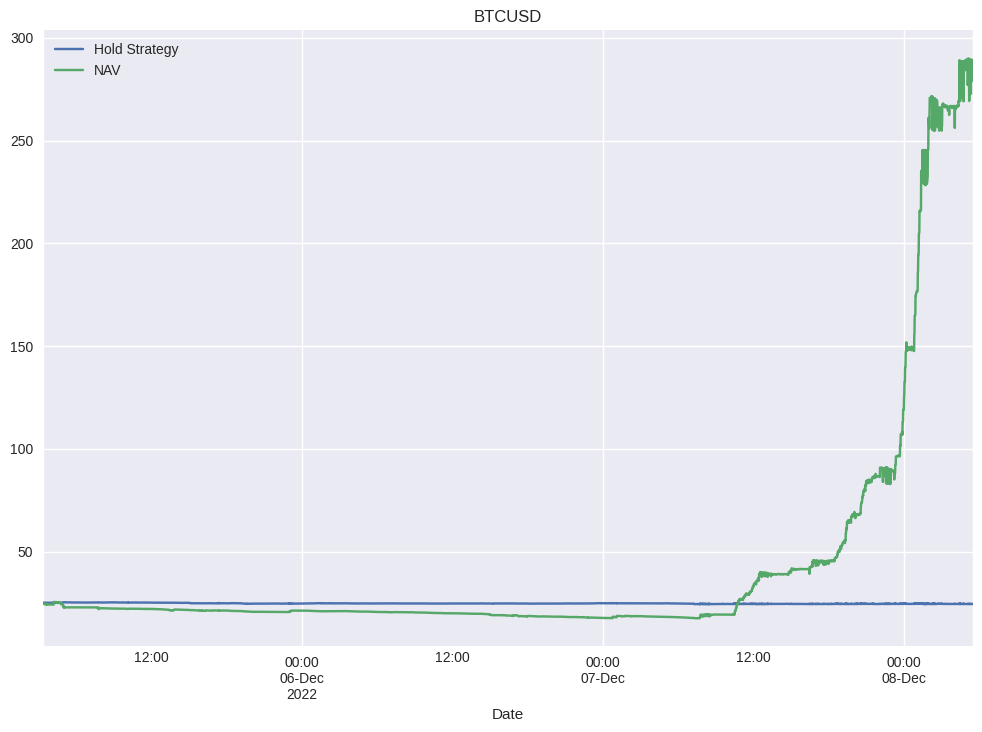

In [28]:
#plot the best strategy!
bc.plot_data(["Hold Strategy", "NAV"])

In [29]:
bc.PnLs

[-0.6221885711395843,
 0.0004445979717018246,
 -0.028122069699526797,
 -0.01284405437724484,
 0.013334166393589154,
 0.025425964225530374,
 0.11762299623311435,
 -1.3426570445706063,
 -0.02238311948821092,
 -0.0013936914422216567,
 -0.023411057302392544,
 0.011694528787356918,
 -0.013210329122714968,
 -0.0025708065296605413,
 -0.00632442481728788,
 0.0028430205124885533,
 0.046637542089370584,
 0.05573640722268736,
 -0.06707864602847138,
 -0.0034825565657695037,
 -0.016495307313312918,
 -0.010359408127006137,
 -0.014486193468624526,
 -0.0029447688239166983,
 0.014591086206384331,
 -0.16750536627591062,
 -0.010799160388336148,
 -0.00513749058647547,
 -0.00974603962947075,
 0.032490044457313495,
 -0.09350170779858366,
 0.07760739516223172,
 -0.011916929468990955,
 -0.016173997911843027,
 -0.014760422050163275,
 -0.010297751674486553,
 0.01860806923142549,
 -0.020667284243577957,
 -0.01111491265715586,
 -0.003939393479412261,
 -0.016920438523216768,
 0.010274359101572473,
 0.0037767581856

552

16